<a href="https://colab.research.google.com/github/afonsotmm/2d-perceptive-modelling-ml/blob/main/2d_perceptive_modelling_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
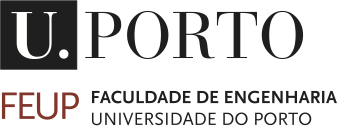   
<h1> <b>Machine Learning 2024/2025 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**Aníbal Matos** (anibal@fe.up.pt),
**Maria Inês Pereira** (maria.ines@fe.up.pt)

FEUP, Mar. 2025

---


# **Identification**

* **Group:** A01_E
* **Name:** Afonso Mateus
* **Student Number:** 202204126

* **Name:** David Brás
* **Student Number:** 202106988



---




**Initial setup:** To download the file **data-set.cvs**, run the next cell.

In [1]:
!wget -O dataset.csv.zip https://www.dropbox.com/s/9y0s2ogjovkwrbm/data-set.csv.zip?dl=0 --quiet
!unzip dataset.csv.zip -d.


Archive:  dataset.csv.zip
replace ./data-set.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Then, run this code to get the data-set

import pandas as pd
df = pd.read_csv('data-set.csv', index_col=0)
df.head()
#df

# By convention, values that are zero signify no measurements.
# The units are:
# [m] for x and y
# [m/s] for the velocities vx and vy
# [m] for the LIDAR ranges

,time,x,y,vx,vy,angle -179,angle -178,angle -177,angle -176,angle -175,...,angle 171,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180
0,0.0,-3.946339,-2.912177,0.711051,-0.307325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1,0.000000,0.000000,0.678366,-0.308563,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.000000,0.000000,0.677682,-0.285029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3,0.000000,0.000000,0.648523,-0.293170,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4,0.000000,0.000000,0.644965,-0.277222,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Part 1: Kalman filter design**



Consider a holonomic mobile robot in the 2D plan and suppose that one can get measurements from its linear velocity every time step $t=0, 0.1, 0.2, \ldots$ (in seconds) and its position every time step $t=0, 0.5, 1.0, 1.5 \ldots$ (in seconds). Suppose also that the measurements are corrupted by additive Gaussian noise and furthermore, the linear velocity measurements may also include a unknown but constant bias term. The goal is to obtain an estimate of the position of the robot together with a measure of its uncertainty. To this end, we will implement a Kalman filter (KF)!

### **Model:**
Let $(x_t, y_t)$ be the position of the robot at time step $t$, and $(v_{x,t}, v_{y,t})$ its linear velocity. Let $(b_{x,t}, b_{y,t})$ be the bias term and $w_t$ and $\eta_t$ Gaussian noises. Then, a state-space model to design the KF can be written as


*x-direction*
\begin{align*}
\begin{bmatrix}
x_{t+1} \\
b_{x,t+1}
\end{bmatrix}
&= \begin{bmatrix}
1 &h \\
0 &1
\end{bmatrix}
\begin{bmatrix}
x_{t} \\
b_{x,t}
\end{bmatrix}
+\begin{bmatrix}
h \\
0
\end{bmatrix}
v_{x,t}
+ w_{x,t} \quad t=0, 0.1, 0.2, \ldots \\
z_{x,t} &=
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
x_{t} \\
b_{x,t}
\end{bmatrix} +  \eta_{x,t}, \quad t=0, 0.5, 1.0, 1.5 \ldots
\end{align*}

*y-direction*
\begin{align*}
\begin{bmatrix}
y_{t+1} \\
b_{y,t+1}
\end{bmatrix}
&= \begin{bmatrix}
1 &h \\
0 &1
\end{bmatrix}
\begin{bmatrix}
y_{t} \\
b_{y,t}
\end{bmatrix}
+\begin{bmatrix}
h \\
0
\end{bmatrix}
v_{y,t}
+ w_{y,t} \quad t=0, 0.1, 0.2, \ldots \\
z_{y,t} &=
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
y_{t} \\
b_{y,t}
\end{bmatrix} +  \eta_{y,t}, \quad t=0, 0.5, 1.0, 1.5 \ldots
\end{align*}
where $(z_{x,t}, z_{y,t})$ is the output vector and $h=0.1\,s$ is the sample time.

**Note:** We have decomposed the model in two decoupled parts (x and y directions). Thus, it is possible to design a KF for each direction.

**1.1**
Implement 2 KFs (one for each direction) and display the evolution along time of the estimated position of the robot and the estimated bias term. Display also the estimated trajectory 2D.

In [3]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from numpy import dot
from numpy import *
from numpy.linalg import inv
from numpy.linalg import det
import random
random.seed(3)

time = df["time"].values
x = df["x"].values
y = df["y"].values
vx = df["vx"].values
vy = df["vy"].values


 ----------------------------------- 
X bias = 0.0938 | Y bias = 0.0897
MES X = 0.0026
MES Y = 0.0011


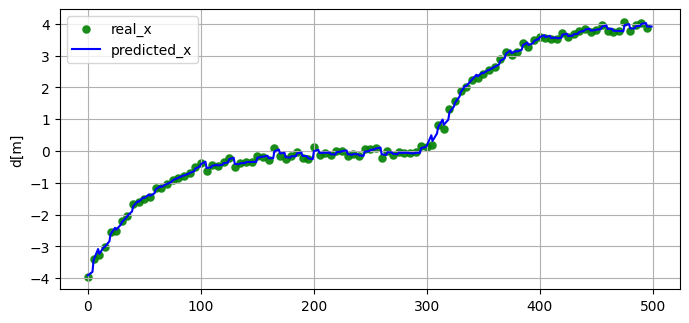

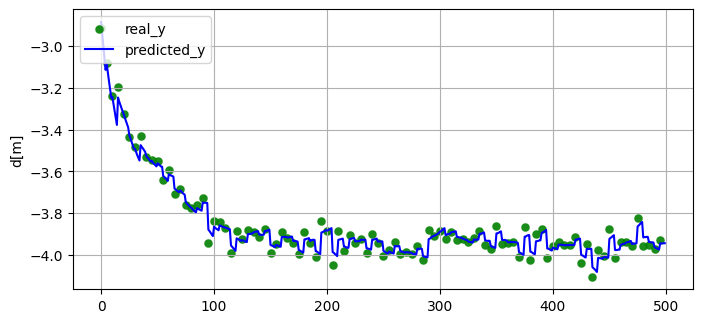

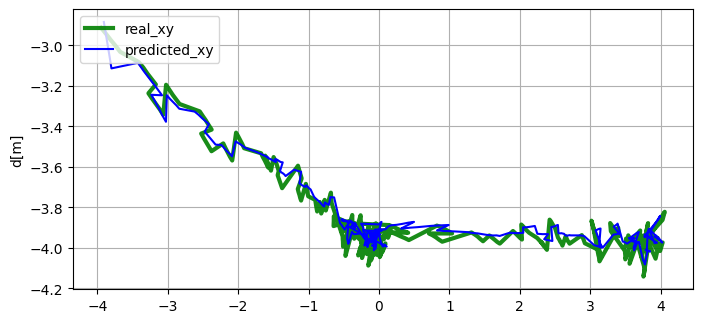

In [4]:
from re import U
#Time step = 100ms
h = 0.1

# Measurmente noise cov
R = np.array([[10]])

#Process noise cov
Q = np.array(np.eye(2) * 1 )

#State
X_x = np.array([[0.0],[0.0]])
X_y = np.array([[0.0],[0.0]])

#State cov
P_x = np.array([[999.0, 0.0],
             [0.0,  999.0]])

P_y = np.array([[999.0, 0.0],
             [0.0,  999.0]])

Y_x = np.array([[0.0]])
Y_y = np.array([[0.0]])

A = np.array([[1.0,  h ],
              [0.0, 1.0]])

B = np.array([[h], [0.0]])

H = np.array([[1.0, 0.0]])


t=0
N_iter = len(time)
t_time = np.zeros(N_iter)
x_time = np.zeros(N_iter)      # position x over time (mean)
y_time = np.zeros(N_iter)
vx_time = np.zeros(N_iter)      # velocity x over time (mean)
vy_time = np.zeros(N_iter)
bx_time = np.zeros(N_iter)
by_time = np.zeros(N_iter)
meas_bx = np.zeros(N_iter)
meas_by = np.zeros(N_iter)
x_sd_time = np.zeros(N_iter)   # position x over time (std_dev)
b_sd_time = np.zeros(N_iter)   # velocity x over time (std_dev)
x_up_time = np.zeros(N_iter)   # d mean + one std_dev
x_dn_time = np.zeros(N_iter)   # d mean - one std_dev
b_up_time = np.zeros(N_iter)   # v mean + one std_dev
b_dn_time = np.zeros(N_iter)   # v mean - one std_dev

#REAL DATA =======================================================================

real_x = 0      # real train position
real_vx = 0      # real train velocity

real_x_time = df["x"].values.copy()   # real train position
real_vx_time = df["vx"].values.copy()   # real train velocity
x_meas = df["x"].values.copy()

real_y_time = df["y"].values.copy()
real_vy_time = df["vy"].values.copy()
y_meas = df["y"].values.copy()

last_x = 0.0

# Kalman Filter Functions

def kf_predict(X, P, A, Q, B, U):
  X = A@X + B@U
  P = A@P@A.T + Q
  return(X, P)

def kf_update(X, P, Y, R, H):
  IS = H@P@H.T + R
  K = P@H.T@inv(IS)
  X = X + K@(Y - H@X)
  P = P - K@IS@K.T
  return (X, P)


# =============================================================================================================

# Fill real_x_time[] with real X data by integrating the speed (+ adding the real position values)

for t in arange(1, N_iter):
  real_x_time[t] = real_x_time[t-1] + real_vx_time[t-1] * h
  real_y_time[t] = real_y_time[t-1] + real_vy_time[t-1] * h
  if (t%5 == 0):
    #print(f"Substituing compute x = {real_x_time[t]} by measured x = {x[t]}")
    real_x_time[t] = x[t]
    real_y_time[t] = y[t]

#
# Kalman Filter loop ============================================================================================
#

mse_x = []
mse_y = []

#r = 0.01
#while (r<10000):
  #r = r * 10
  #R = np.array([[r]])

for t in arange(0, N_iter):
  if t == 0:
    meas_bx[t] = 0
  else:
    meas_bx[t] = meas_bx[t-1]

  #Store velocity in input
  U_x = np.array([[real_vx_time[t]]])
  U_y = np.array([[real_vy_time[t]]])

  (X_x, P_x) = kf_predict(X_x, P_x, A, Q, B, U_x)   #Predict state with Model
  (X_y, P_y) = kf_predict(X_y, P_y, A, Q, B, U_y)

  if t%5 ==0:
    Y_x = np.array([x_meas[t]])                     #Update output (measurement) every 5 iterations
    Y_y = np.array([y_meas[t]])
    meas_by[t] = Y_y[0].item() - X_y[0].item()
    meas_bx[t] = Y_x[0].item() - X_x[0].item()
    (X_x, P_x) = kf_update(X_x, P_x, Y_x, R, H)     #Update state predicitons with measurements every 5 iterations
    (X_y, P_y) = kf_update(X_y, P_y, Y_y, R, H)

  t_time[t] = t
  x_time[t] = X_x[0].item()
  bx_time[t] = X_x[1].item()
  y_time[t] = X_y[0].item()
  by_time[t] = X_y[1].item()


# ==================================== Plotting ==========================================

fig = plt.figure(figsize=(8,8))
chart1 = fig.add_subplot(211)
chart1.scatter(t_time[::5], real_x_time[::5], label='real_x', c="g", linewidth=0.1, alpha=0.9)
chart1.plot(t_time, x_time, label='predicted_x', c="b")
plt.legend(loc='upper left')
chart1.set_ylabel('d[m]')
plt.grid()

fig1 = plt.figure(figsize=(8,8))
chart3 = fig1.add_subplot(211)
chart3.scatter(t_time[::5], real_y_time[::5], label='real_y', c="g", linewidth=0.1, alpha=0.9)
chart3.plot(t_time, y_time, label='predicted_y', c="b")
plt.legend(loc='upper left')
chart3.set_ylabel('d[m]')
plt.grid()

fig1 = plt.figure(figsize=(8,8))
chart4 = fig1.add_subplot(212)
chart4.plot(real_x_time, real_y_time, label='real_xy', c="g", linewidth=3, alpha=0.9)
chart4.plot(x_time, y_time, label='predicted_xy', c="b")
plt.legend(loc='upper left')
chart4.set_ylabel('d[m]')
plt.grid()

print(" ----------------------------------- ")

print(f"X bias = {round(bx_time.mean(),4)} | Y bias = {round(by_time.mean(),4)}")
print(f"MES X = {round(np.mean((real_x_time - x_time)**2),4)}")
print(f"MES Y = {round(np.mean((real_y_time - y_time)**2),4)}")


# Explanation

The choice of values for the R and Q matrixes are related to the ability of the Kalman Filter to correct the estimation with the observations and filter out any unwanted noise. The higher the value choosen for Q is (in relation to R), the more the filter "trusts" the observations (position) for its estimation. On the other hand, the higher R is, the more the filter trusts the model's dynamics equations.

This can also be seen as a Low Pass Filter where R is inversly proportional to its bandwith. This is due to the fact that R represents the covariance of the observations - meaning that lower covariance (i.e., lower R) translates to a higher weight for the received measurements being taken in consideration by the filter, resulting in an estimation more sensitive to variations. The filter will converge quicker to the "expected value", but any noise in the measurements will be heavily reflected its output.

In order to

# **Part 2: Linear Regression**



In this part, the aim is to build a map of the environment by combining the position of the robot with the measurements of the 2D **LIDAR** that is on-board of the robot. The LIDAR measurements consist of range (distance) from the robot to a possible obstacle for each degree of direction, that is,
$$
r_t = \{r_\beta + \eta_r : \beta=-179^o, -178^o, \ldots, 0^o, \ldots, 180^o\}
$$
where $\eta_r$ is assumed to be Gaussian noise. The sample time is the same, that is, $h=0.1\,s$, but the LIDAR measurements are outputted every time step $t=0,0.5,1.0, 1.5, \ldots$ (in seconds) like the robot position in the previous exercise. Moreover, if there is no obstacle within the direction of the laser range or if it is far away, that is, if the distance is greater than $5\,m$, by convention the range measurement is set to zero. It may also happen that the LIDAR in some cases may output an *outlier*.

The next figure shows $r_t$ as a function of the angle $\beta$ for $t=6.0\,s$.

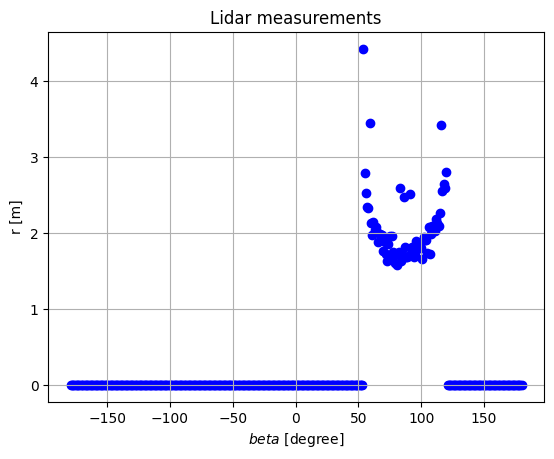

In [5]:

time = df["time"].values
#Seleciona as colunas referentes às medidas do LiDAR
Lidar_range = df.iloc[:, np.arange(5,365,1)].values

t=6*10 # t = 6 sec * 1/sample_time // Index 60 corresponde à 60ª medição, feita de 100ms em 100ms, logo, para t=6s
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();



**2.1**
Using the estimated position of the robot (computed in the previous exercise) and the LIDAR data,
1. Obtain the cloud points in the 2D plan that the robot sense at **$t=6\,s$** and plot them. Do not forget to remove the zero ranges and note that  

$$
\begin{align*}
\hat x_{o,t} = \hat x_t + r_t \cos\beta \\
\hat y_{o,t} = \hat y_t + r_t \sin\beta
\end{align*}
$$

2. Perform a linear regression for the previous data using a model of the type
\begin{equation} \color{green} { y = \theta_0 + \theta_1 x }
 \end{equation}
and display the results, that is, display the resulting 2d map, the mean square error, and the optimal parameters for $\color{green} \theta$. To this end, apply the related Least Square (LS) normal equations and **only use** the sklearn to confirm the obtained values.



<Figure size 640x480 with 0 Axes>

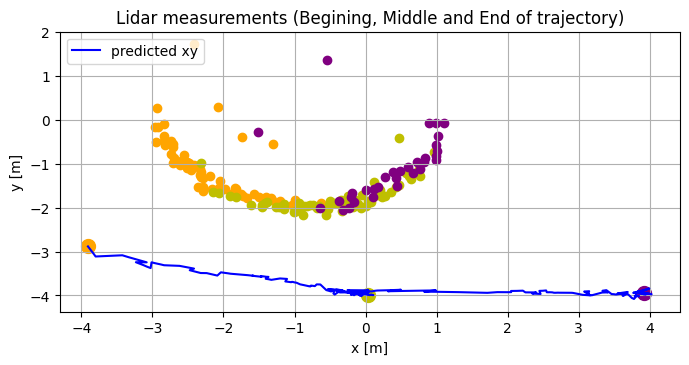

In [6]:
# Part 2.1.1

#Build the cloud points in 2D plan

X_o_init = []
Y_o_init = []

X_o_mid = []
Y_o_mid = []

X_o_end = []
Y_o_end = []

d2r = 3.1415/180

t = 0
lidar_meas = Lidar_range[t]
for i in range(0, 359):
  if lidar_meas[i] > 0:
    x_meas = lidar_meas[i]*cos((i-179)*d2r) + x_time[t]
    y_meas = lidar_meas[i]*sin((i-179)*d2r) + y_time[t]
    X_o_init.append(x_meas)
    Y_o_init.append(y_meas)

X_o_init = np.array(X_o_init)
Y_o_init = np.array(Y_o_init)
sorted_indices_init = np.argsort(X_o_init)
x_o_init = X_o_init[sorted_indices_init]
y_o_init = Y_o_init[sorted_indices_init]

t=250
lidar_meas = Lidar_range[t]
for i in range(0, 359):
  if lidar_meas[i] > 0:
    x_meas = lidar_meas[i]*cos((i-179)*d2r) + x_time[t]
    y_meas = lidar_meas[i]*sin((i-179)*d2r) + y_time[t]
    X_o_mid.append(x_meas)
    Y_o_mid.append(y_meas)

X_o_mid = np.array(X_o_mid)
Y_o_mid = np.array(Y_o_mid)
sorted_indices_mid = np.argsort(X_o_mid)
x_o_mid = X_o_mid[sorted_indices_mid]
y_o_mid = Y_o_mid[sorted_indices_mid]

t=495
lidar_meas = Lidar_range[t]
for i in range(0, 359):
  if lidar_meas[i] > 0:
    x_meas = lidar_meas[i]*cos((i-179)*d2r) + x_time[t]
    y_meas = lidar_meas[i]*sin((i-179)*d2r) + y_time[t]
    X_o_end.append(x_meas)
    Y_o_end.append(y_meas)

X_o_end = np.array(X_o_end)
Y_o_end = np.array(Y_o_end)
sorted_indices_end = np.argsort(X_o_end)
x_o_end = X_o_end[sorted_indices_end]
y_o_end = Y_o_end[sorted_indices_end]

plt.figure()
fig1 = plt.figure(figsize=(8,8))
chart4 = fig1.add_subplot(212)
chart4.plot(x_time, y_time, label='predicted xy', c="b")
plt.legend(loc='upper left')
chart4.set_ylabel('d[m]')
chart4.scatter(x_o_init, y_o_init, color='orange')
chart4.scatter(x_o_mid, y_o_mid, color='y')
chart4.scatter(x_o_end, y_o_end, color='purple')
chart4.scatter(x_time[0], y_time[0], color='orange', marker='o', s=100, label="Single Point")
chart4.scatter(x_time[250], y_time[250], color='y', marker='o', s=100, label="Single Point")
chart4.scatter(x_time[495], y_time[495], color='purple', marker='o', s=100, label="Single Point")
plt.title('Lidar measurements (Begining, Middle and End of trajectory)')
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.grid();


Theta = [-1.64169714  0.03752766]
Mean Squared Error (MSE): 0.1297


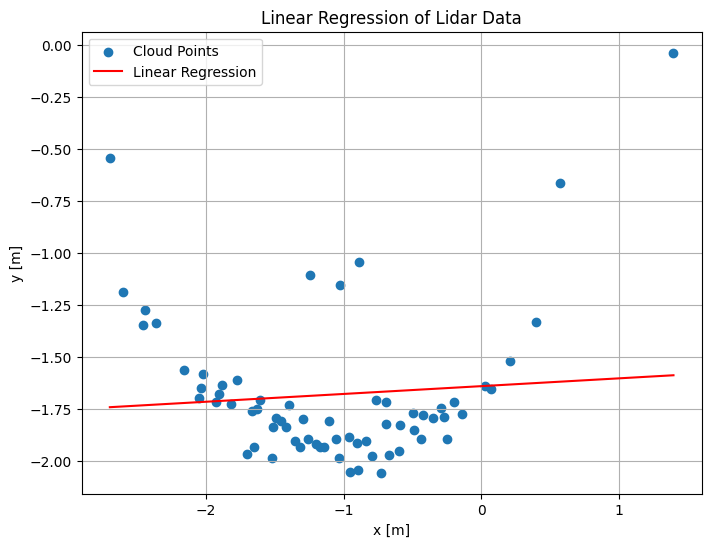

In [7]:
# Part 2.1.2

#To complete

t = 60

X_o_m =[]
Y_o_m = []

lidar_meas = Lidar_range[t]
for i in range(0, 359):
  if lidar_meas[i] > 0:
    x_meas = lidar_meas[i]*cos((i-179)*d2r) + x_time[t]
    y_meas = lidar_meas[i]*sin((i-179)*d2r) + y_time[t]
    X_o_m.append(x_meas)
    Y_o_m.append(y_meas)

X_o_m = np.array(X_o_m)
Y_o_m = np.array(Y_o_m)
sorted_indices_init = np.argsort(X_o_m)
x_o_m = X_o_m[sorted_indices_init]
y_o_m = Y_o_m[sorted_indices_init]

x_Li = x_o_m[x_o_m != 0].reshape(-1, 1)  # Selecting non-zero values and reshaping to a column vector
X = np.concatenate([np.ones_like(x_Li), x_Li], axis=1)  # Adding a column of ones for the intercept term (theta_0)  -> dim = Nx2

y_Li = y_o_m[x_o_m != 0]                                    #Only select Y values for the indexes where X != 0

# Linear Regression Formula
theta = inv(X.T@X)@X.T@y_Li # -> dim = 2x1

print(f"Theta = {theta}")

y_pred = X@theta

MSE = np.mean((y_Li - y_pred)**2)
print(f"Mean Squared Error (MSE): {round(MSE,4)}")

plt.figure(figsize=(8, 6))
plt.scatter(x_Li, y_Li, label='Cloud Points')
plt.plot(x_Li, y_pred, color='red', label='Linear Regression')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Linear Regression of Lidar Data')
plt.legend()
plt.grid(True)
plt.show()

**2.2**
Repeat the previous exercise but now with a polynomial model of the type
\begin{equation} \color{green} { y = \theta_0 + \theta_1 x + \theta_2 x^2 }
 \end{equation}



Theta = [-1.55848999  0.64603257  0.31813233]
(3,) (67, 3) (67,)
Mean Squared Error (MSE): 0.0415


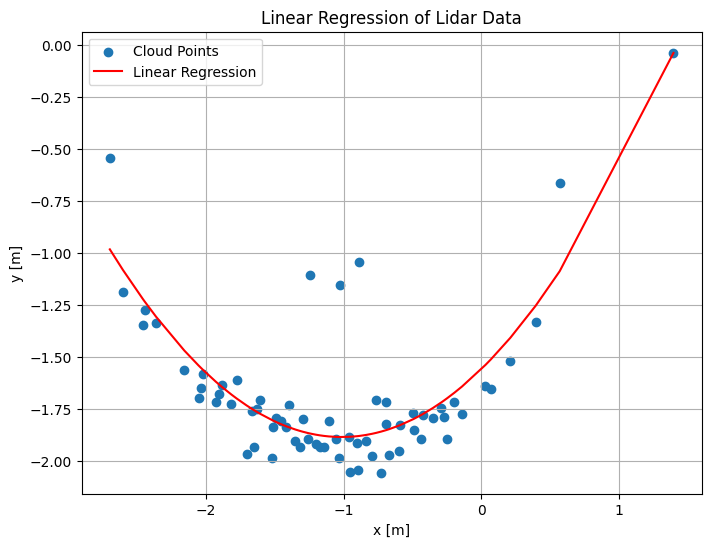

In [8]:
# To complete

x_Li = x_o_m[x_o_m != 0].reshape(-1, 1)  # Selecting non-zero values and reshaping to a column vector
X = np.concatenate([np.ones_like(x_Li), x_Li], axis=1)  # Adding a column of ones for the intercept term (theta_0)  -> dim = Nx3
X = np.concatenate([X, X[:,1:2]**2], axis=1)
y_Li = y_o_m[x_o_m != 0]                                    #Only select Y values for the indexes where X != 0

# Linea Regression Formula
theta = inv(X.T@X)@X.T@y_Li # -> dim = 3x1

print(f"Theta = {theta}")

y_pred = X@theta

print(theta.shape, X.shape, y_pred.shape)

MSE = np.mean((y_Li - y_pred)**2)
print(f"Mean Squared Error (MSE): {round(MSE,4)}")

plt.figure(figsize=(8, 6))
plt.scatter(x_Li, y_Li, label='Cloud Points')
plt.plot(x_Li, y_pred, color='red', label='Linear Regression')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Linear Regression of Lidar Data')
plt.legend()
plt.grid(True)
plt.show()

**2.3**
At this point you can use sklearn!
Do the same as the previous exercise (polynomial model) but now with **degree 10**. Moreover, implement also a regression with **Ridge** regularization and a regression with **LASSO** regularization. Do not forget to display the obtained results. What can you conclude?




Testing MSE (Ridge Model): 0.074
Testing MSE (LASSO Model): 0.086


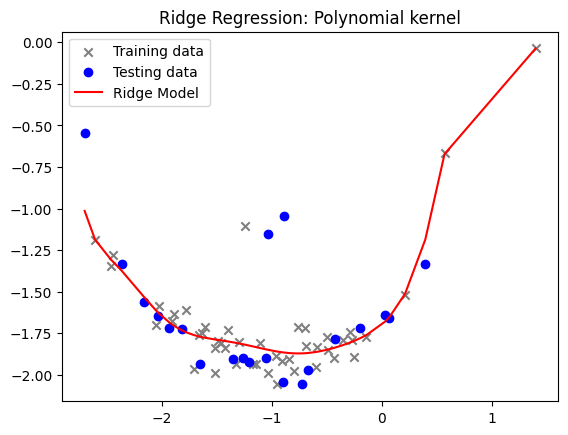

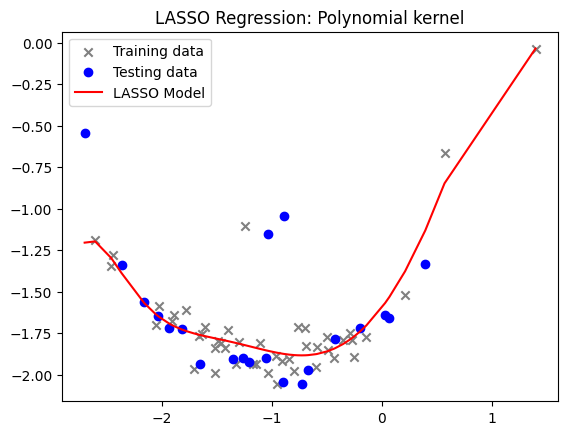

In [9]:
# To complete

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

x_train, x_test, y_train, y_test = train_test_split(x_Li, y_Li, test_size=0.3, random_state=42)

ridge_degree = 10
lasso_degree = 10

#Ridge Model
gauss_model_ridge = make_pipeline(PolynomialFeatures(ridge_degree), Ridge(alpha=0.001, max_iter=10**7))
gauss_model_ridge.fit(x_train, y_train)
#print("Training MSE (Ridge Model):", round(np.mean((y_train - gauss_model_ridge.predict(x_train))**2), 3))
print("Testing MSE (Ridge Model):", round(np.mean((y_test - gauss_model_ridge.predict(x_test))**2), 3))

ydraw_ridge = gauss_model_ridge.predict(x_Li)

# Lasso Model
gauss_model_lasso = make_pipeline(PolynomialFeatures(lasso_degree), Lasso(alpha=0.001, max_iter=10**7))
gauss_model_lasso.fit(x_train, y_train)
#print("Training MSE (LASSO Model):", round(np.mean((y_train - gauss_model_lasso.predict(x_train))**2), 3))
print("Testing MSE (LASSO Model):", round(np.mean((y_test - gauss_model_lasso.predict(x_test))**2), 3))

ydraw_lasso = gauss_model_lasso.predict(x_Li)

#Plots
legend_fitting_model_ridge = 'Ridge model: n{}'.format(ridge_degree)
plt.scatter(x_train, y_train,  color="gray", marker="x", label='Training data')
plt.scatter(x_test, y_test,  color="blue", marker="o", label='Testing data')
plt.plot(x_Li, ydraw_ridge, color="red", label="Ridge Model")
plt.legend(loc ="best")
plt.title("Ridge Regression: Polynomial kernel")
plt.show()

# Plots para o modelo LASSO
legend_fitting_model_lasso = 'LASSO model: n{}'.format(lasso_degree)
plt.scatter(x_train, y_train, color="gray", marker="x", label='Training data')
plt.scatter(x_test, y_test, color="blue", marker="o", label='Testing data')
plt.plot(x_Li, ydraw_lasso, color="red", label="LASSO Model")
plt.legend(loc="best")
plt.title("LASSO Regression: Polynomial kernel")
plt.show()



**2.4**
We now would like to use all the LIDAR data. One simple option (off-line) is to make a data set with all the cloud point positions in 2D and apply the linear regression techniques.

Using sklearn, do this for LS, LS+Ridge, LS+LASSO using the polynomial model of degree 10. Display the results (map 2D) and the optimal values for
$\color{green} \theta$.


(500, 360)
First LiDAR measurement found at (-0.63,-1.88) on row = 0 col = 196
5342 non-null LiDAR measurements found
Testing MSE (Quadratic Model):  0.464
Testing MSE (Ridge Model): 0.494
Testing MSE (LASSO Model): 0.476


<Figure size 640x480 with 0 Axes>

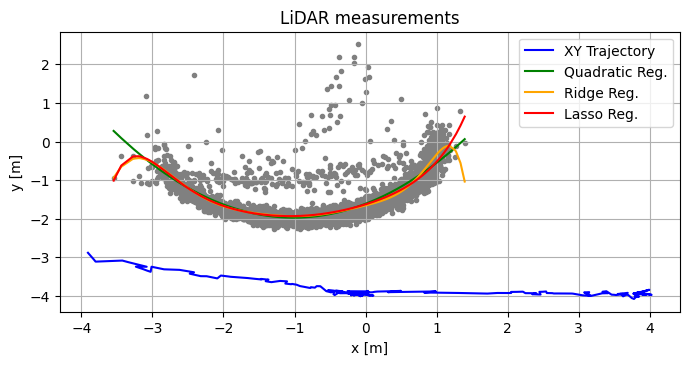

In [11]:
# To complete

columns = 360
rows = 500

X_o = []
Y_o = []

d2r = 3.1415/180

non_null = 0
first = False

print(Lidar_range.shape)

for i in range(rows):       # i = instante de tempo
  for j in range(columns):  # j = ângulo
    if Lidar_range[i][j] > 0:
      x_point = Lidar_range[i][j]*cos((j-179)*d2r) + x_time[i]
      y_point= Lidar_range[i][j]*sin((j-179)*d2r) + y_time[i]
      X_o.append(x_point)
      Y_o.append(y_point)
      if first==False:
        first = True
        x_f = x_point
        y_f = y_point
        print(f"First LiDAR measurement found at ({round(x_f,2)},{round(y_f,2)}) on row = {i} col = {j}")
      non_null+=1

print(f"{non_null} non-null LiDAR measurements found")

# Get the sorted indices for X
sorted_indices = np.argsort(X_o)

#Convert arrar to Numpy Array
X_o = np.array(X_o)
Y_o = np.array(Y_o)

# Reorder X and Y based on the sorted indices
x_o = X_o[sorted_indices]
y_o = Y_o[sorted_indices]

x_o = x_o[x_o != 0].reshape(-1, 1)
#y_o = y_o[x_o != 0].reshape(-1, 1)

X_TR = np.concatenate([np.ones_like(x_o), x_o], axis=1)
X_TR = np.concatenate([X_TR, X_TR[:,1:2]**2], axis=1)

#Quadratic Regression
theta = inv(X_TR.T @ X_TR) @ X_TR.T @ y_o
theta = theta.reshape(-1, 1)
y_predict = X_TR @ theta

print("Testing MSE (Quadratic Model): ", round(np.mean((y_predict - y_o)**2),3))

x_train, x_test, y_train, y_test = train_test_split(x_o, y_o, test_size=0.3, random_state=42)

x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1,1)

ridge_degree = 10
lasso_degree = 10

#Ridge Model
gauss_model_ridge = make_pipeline(PolynomialFeatures(ridge_degree), Ridge(alpha=0.01, max_iter=10**8))
gauss_model_ridge.fit(x_train, y_train)
print("Testing MSE (Ridge Model):", round(np.mean((y_test - gauss_model_ridge.predict(x_test))**2), 3))

ydraw_ridge = gauss_model_ridge.predict(x_o)

# Lasso Model
gauss_model_lasso = make_pipeline(PolynomialFeatures(lasso_degree), Lasso(alpha=0.01, max_iter=10**8))
gauss_model_lasso.fit(x_train, y_train)
print("Testing MSE (LASSO Model):", round(np.mean((y_test - gauss_model_lasso.predict(x_test))**2), 3))

ydraw_lasso = gauss_model_lasso.predict(x_o)

plt.figure()
fig1 = plt.figure(figsize=(8,8))
chart4 = fig1.add_subplot(212)
chart4.plot(x_time, y_time, label='XY Trajectory', c="b")
chart4.set_ylabel('d[m]')
chart4.scatter(x_o, y_o, color='gray', marker=".")
chart4.plot(x_o, y_predict, label='Quadratic Reg.', color = 'g')
chart4.plot(x_o, ydraw_ridge, label='Ridge Reg.',color = 'orange')
chart4.plot(x_o, ydraw_lasso, label='Lasso Reg.', color = 'red')
plt.legend(loc='upper right')
plt.title('LiDAR measurements')
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.grid();

# **Side Note**

>In this specific case, the Quadratic model outperforms both Lasso and Ridge, as it provides a better fit and lower Mean Squared Error (MSE). While Lasso is more effective than Ridge, as Ridge only drives the parameters close to zero, Lasso actually sets to zero, making it more effective at filtering out unnecessary parameters and controlling model complexity.